In [1]:
%env CUDA_VISIBLE_DEVICES=2


env: CUDA_VISIBLE_DEVICES=2


In [2]:
#-*- coding:utf-8 -*-
import os
import json
import threading
import numpy as np
from PIL import Image

import tensorflow as tf
import keras
from keras import losses
from keras import backend as K
from keras.utils import plot_model
from keras.preprocessing import image
from keras.preprocessing.sequence import pad_sequences
from keras.layers import Input, Dense, Flatten
from keras.layers.core import Reshape, Masking, Lambda, Permute
from keras.layers.recurrent import GRU, LSTM
from keras.layers.wrappers import Bidirectional, TimeDistributed
from keras.layers.normalization import BatchNormalization
from keras.layers.convolutional import Conv2D, MaxPooling2D, ZeroPadding2D
from keras.optimizers import SGD, Adam
from keras.models import Model
from keras.callbacks import EarlyStopping, ModelCheckpoint, LearningRateScheduler, TensorBoard

from imp import reload
import densenet


Using TensorFlow backend.


In [3]:

class DataGenerator(keras.utils.Sequence):
    'Generates data for Keras'
    def __init__(self, dataset_dir,list_IDs, labels, batch_size=32, dim=(32,32,32), n_channels=1,
                 characters='', shuffle=True,maxLabelLength=10):
        'Initialization'
        self.dim = dim
        self.batch_size = batch_size
        self.labels = labels
        self.list_IDs = list_IDs
        self.n_channels = n_channels
        self.characters = characters
        self.n_classes = len(self.characters)
        self.shuffle = shuffle
        self.on_epoch_end()
        self.dataset_dir = dataset_dir
        self.maxLabelLength = maxLabelLength

    def __len__(self):
        'Denotes the number of batches per epoch'
        return int(np.floor(len(self.list_IDs) / self.batch_size))

    def __getitem__(self, index):
        'Generate one batch of data'
        # Generate indexes of the batch
        indexes = self.indexes[index*self.batch_size:(index+1)*self.batch_size]

        # Find list of IDs
        list_IDs_temp = [self.list_IDs[k] for k in indexes]

        # Generate data
        X, y = self.__data_generation(list_IDs_temp)

        return X, y

    def on_epoch_end(self):
        'Updates indexes after each epoch'
        self.indexes = np.arange(len(self.list_IDs))
        if self.shuffle == True:
            np.random.shuffle(self.indexes)

    def __data_generation(self, list_IDs_temp):
        'Generates data containing batch_size samples' # X : (n_samples, *dim, n_channels)
        # Initialization
        X = np.zeros((self.batch_size, *self.dim, self.n_channels), dtype=np.float)
        Y = np.ones([self.batch_size, self.maxLabelLength],dtype=int) * 10000
        input_length = np.zeros([self.batch_size, 1])
        label_length = np.zeros([self.batch_size, 1])
        
        
        # Generate data
        for i, ID in enumerate(list_IDs_temp):
            # Store sample
            try:
                img = Image.open(os.path.join(self.dataset_dir, ID)).convert('L')
                img = img.resize((self.dim[1],self.dim[0]))
                img = np.array(img, 'f') / 255.0 - 0.5
            except (OSError,IOError) as error:
                print(error)
                img = np.zeros(*self.dim,dtype=np.float)
                

            X[i,] = np.expand_dims(img, axis=2)
            
            label_origin = self.labels[ID]
            label_origin.replace(' ','')
            label = self.__one_hot(label_origin,length=len(label_origin))


            if(len(label) <= 0):
                print("%s label len < 0" %ID)
            # the input length for ctc_loss, for densenet pool size is about 8
            label_length[i] = len(label)
            input_length[i] = self.dim[1] // 8
            Y[i, :len(label)] = label
    
            
        inputs = {'the_input': X,
            'the_labels': Y,
            'input_length': input_length,
            'label_length': label_length,
            }
        outputs = {'ctc': np.zeros([self.batch_size])}
        return inputs, outputs

    def __one_hot(self, text,length):
        length = min(length,self.maxLabelLength)
        label = np.zeros(length)
        for i, char in enumerate(text):
            index = self.characters.find(char)
            if index == -1:
                index = self.characters.find(u'.')
            if i < length:
                label[i] = index
        return label



In [29]:
import json
import sys 
sys.path.append('/mnt/wuwenhui/git_ocr_project/chinese_ocr_densenet/densenet/')
import keys_keras


img_h = 32
img_w = 280
batch_size = 512
maxlabellength = 10
epochs = 100


label_path = './images/dataset_len10_v1/'
# label_valid_path  = './images/medicine_dataset_v3/'
with open(label_path+'train/train_label.json','r',encoding='utf-8') as json_file:
    label_dict_train=json.load(json_file) 

with open(label_path+'valid/valid_label.json','r',encoding='utf-8') as json_file:
    label_dict_valid=json.load(json_file)


len(label_dict_train),len(label_dict_valid)



(397530, 26100)

In [24]:
train_id = list(label_dict_train.keys())
valid_id = list(label_dict_valid.keys())
# characters = keys.alphabet[:]
characters = keys_keras.alphabet_union[1:]+'卍'
# characters = ''.join([ch.strip('\n') for ch in characters][1:] + ['卍'])
nclass = len(characters)
print(nclass)
train_generator = DataGenerator(dataset_dir=label_path+'train/', list_IDs=train_id, 
                                labels=label_dict_train,batch_size = batch_size, characters=characters,
                                dim=(img_h,img_w),maxLabelLength=maxlabellength)
valid_generator = DataGenerator(dataset_dir=label_path+'valid/', list_IDs=valid_id, 
                                labels=label_dict_valid,batch_size = batch_size, characters=characters,
                                dim=(img_h,img_w),maxLabelLength=maxlabellength)

6043


### 观测数据batch 的情况

106
(128, 1) [3675 2394 5012 5835  834 1306 1167 4783  789 5649]


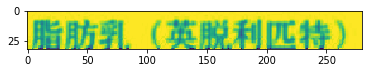

In [25]:
import matplotlib.pyplot as plt
%matplotlib inline
train_generator.on_epoch_end()
iterator = iter(train_generator)

X,y = iterator.__next__()
i = np.random.randint(0,X['the_labels'].shape[0])
# train_generator.on_epoch_end()
print(i)
print(X['input_length'].shape,X['the_labels'][i])
image = np.squeeze(X['the_input'][i])
plt.imshow(image)



### 载入模型函数

In [26]:
import imp 
imp.reload(densenet)
def ctc_lambda_func(args):
    y_pred, labels, input_length, label_length = args
    return K.ctc_batch_cost(labels, y_pred, input_length, label_length)

def get_model(img_h, nclass):
    input = Input(shape=(img_h, None, 1), name='the_input')
    y_pred = densenet.dense_cnn(input, nclass)

    basemodel = Model(inputs=input, outputs=y_pred)
    basemodel.summary()

    labels = Input(name='the_labels', shape=[None,], dtype='float32')
    input_length = Input(name='input_length', shape=[1], dtype='int64')
    label_length = Input(name='label_length', shape=[1], dtype='int64')

    loss_out = Lambda(ctc_lambda_func, output_shape=(1,), name='ctc')([y_pred, labels, input_length, label_length])

    model = Model(inputs=[input, labels, input_length, label_length], outputs=loss_out)

    return basemodel, model

import keys
def get_model_origin_conv(img_h, nclass):
    old_nClass = len(keys.alphabet[:])
    input = Input(shape=(img_h, None, 1), name='the_input')
    y_pred_old = densenet.dense_cnn(input, old_nClass)

    basemodel = Model(inputs=input, outputs=y_pred_old)
    basemodel.load_weights(modelPath)
    flatten = basemodel.get_layer('flatten').output
    y_pred = Dense(nclass, name='y_pred_out', activation='softmax')(flatten)

    labels = Input(name='the_labels', shape=[None,], dtype='float32')
    input_length = Input(name='input_length', shape=[1], dtype='int64')
    label_length = Input(name='label_length', shape=[1], dtype='int64')

    loss_out = Lambda(ctc_lambda_func, output_shape=(1,), name='ctc')([y_pred, labels, input_length, label_length])

    model = Model(inputs=[input, labels, input_length, label_length], outputs=loss_out)

    return basemodel, model




In [27]:

# char_set = open('char_std_5990.txt', 'r', encoding='utf-8').readlines()
# char_set = ''.join([ch.strip('\n') for ch in char_set][1:] + ['卍'])


nclass = len(characters)
print(len(characters))
# K.set_session(get_session())
reload(densenet)


config = tf.ConfigProto()
## 这里设置gpu内存的比例
config.gpu_options.per_process_gpu_memory_fraction = 0.4
config.gpu_options.allow_growth = True
# session = tf.Session(config=config)
# one gpu!!!
with tf.Session(config=config) as sess:
    basemodel, model = get_model(img_h, nclass)
    for layer in model.layers[:75]:
        layer.trainable = False
    for layer in model.layers:
        print(layer.name,layer.trainable)

model.compile(loss={'ctc': lambda y_true, y_pred: y_pred}, optimizer='adam', metrics=['accuracy'])

modelPath = '../train/models/75layers_labeled_ch_len25_v1-2.999-0.502.h5'   
if os.path.exists(modelPath):
    print("Loading model weights...")
    model.load_weights(modelPath)
    print('done!')
    
## multi-gpu model
# from keras.utils import multi_gpu_model
# with tf.device('/cpu:0'):
#     basemodel, model = get_model(img_h, nclass)


# parallel_model = multi_gpu_model(model,gpus=2)
# parallel_model.compile(loss={'ctc': lambda y_true, y_pred: y_pred}, optimizer='adam', metrics=['accuracy'])
    








6043
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
the_input (InputLayer)          (None, 32, None, 1)  0                                            
__________________________________________________________________________________________________
conv1/conv (Conv2D)             (None, 16, None, 64) 1600        the_input[0][0]                  
__________________________________________________________________________________________________
conv2_block1_0_bn (BatchNormali (None, 16, None, 64) 256         conv1/conv[0][0]                 
__________________________________________________________________________________________________
conv2_block1_0_relu (Activation (None, 16, None, 64) 0           conv2_block1_0_bn[0][0]          
__________________________________________________________________________________________________
conv2

Loading model weights...
done!


## single gpu training

In [ ]:


checkpoint = ModelCheckpoint(filepath='./models/freezen_75layers_dataset_v1-{val_loss:.3f}-{val_acc:.3f}.h5', monitor='val_loss', save_best_only=True, save_weights_only=True)
lr_schedule = lambda epoch: 0.0005 * 0.90**epoch
learning_rate = np.array([lr_schedule(i) for i in range(epochs)])
changelr = LearningRateScheduler(lambda epoch: float(learning_rate[epoch]))
earlystop = EarlyStopping(monitor='val_acc', patience=5, verbose=1)
tensorboard = TensorBoard(log_dir='./models/logs', write_graph=True)

print(lr_schedule)
print('-----------Start training-----------')
model.fit_generator(train_generator,
    steps_per_epoch = len(train_generator),
    epochs = epochs,
    initial_epoch = 0,
    validation_data = valid_generator,
    callbacks = [checkpoint, earlystop, changelr, tensorboard],
    workers=4,
    use_multiprocessing=True)


<function <lambda> at 0x7f92443ce8c8>
-----------Start training-----------
Epoch 1/100
 363/3105 [==>...........................] - ETA: 22:14 - loss: 0.2524 - acc: 0.9341

## multi gpu training

In [ ]:
checkpoint = ModelCheckpoint(filepath='./models/random_len10-{epoch:02d}-{val_loss:.3f}-{val_acc:.3f}.h5', monitor='val_loss', save_best_only=False, save_weights_only=True)
lr_schedule = lambda epoch: 0.0005 * 0.90**epoch
learning_rate = np.array([lr_schedule(i) for i in range(epochs)])
changelr = LearningRateScheduler(lambda epoch: float(learning_rate[epoch]))
earlystop = EarlyStopping(monitor='val_acc', patience=5, verbose=1)
tensorboard = TensorBoard(log_dir='./models/logs', write_graph=True)

print(lr_schedule)
print('-----------Start training-----------')
parallel_model.fit_generator(train_generator,
    steps_per_epoch = len(train_generator),
    epochs = epochs,
    initial_epoch = 0,
    validation_data = valid_generator,
    callbacks = [checkpoint, earlystop, changelr, tensorboard],
    workers = 3)

In [ ]:
conv4_block8_1_conv = keras.backend.get_value(model.get_layer('conv4_block8_1_conv').weights[0])
bias =  keras.backend.get_value(model.get_layer('conv4_block8_1_conv').weights[1])

In [ ]:
conv4_block8_1_conv_1 = keras.backend.get_value(model.get_layer('conv4_block8_1_conv').weights[0])
bias_1 =  keras.backend.get_value(model.get_layer('conv4_block8_1_conv').weights[1])

In [ ]:
bias==bias_1